In [1]:
import nibabel as nib
import numpy as np

In [10]:
#prepare arrays:

func_array = np.load("/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10329/func/sub-10329_diff_wm_2vol_ts_1vol.npy")
func_array.shape
func_array = np.expand_dims(func_array, axis=1)
func_array.shape
func_array = np.expand_dims(func_array, axis=2)
func_array.shape

conn_array = np.loadtxt("/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10329/dwi/association_matrix_sub-10329.csv",
                 delimiter=",", dtype=float)
conn_array.shape
conn_array = np.expand_dims(conn_array, axis=2)
conn_array.shape
conn_array = np.expand_dims(conn_array, axis=3)
conn_array.shape


(454, 454, 1, 1)

In [37]:
import numpy as np
from scipy.stats import ttest_1samp
import h5py

# Assuming taskActMatrix and connMatrix are numpy arrays
taskActMatrix = func_array
connMatrix = conn_array # shape 

numTasks = taskActMatrix.shape[1]
numRegions = taskActMatrix.shape[0]
numConnStates = connMatrix.shape[2]
numSubjs = connMatrix.shape[3]

# Setup for prediction
taskPredMatrix = np.zeros((numRegions, numTasks, numSubjs))
taskPredRs = np.zeros((numTasks, numSubjs))
taskActualMatrix = taskActMatrix
regionNumList = np.arange(numRegions)

/home/gabridele/miniconda3/envs/mrtrix3/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [40]:
import ActflowToolbox as actflow
restFC_corr=np.zeros((numRegions,numRegions,numSubjs))
scount=0
for subj in numSubjs:
    restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(connMatrix[:,:,scount])
    scount += 1
print("==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(taskActMatrix, restFC_corr)

ImportError: Numba needs NumPy 1.21 or less

In [45]:
import scipy
import matplotlib
for subjNum in range(numSubjs):
    for taskNum in range(numTasks):

        # Get this subject's activation pattern for this task
        taskActVect = taskActMatrix[:, taskNum, subjNum]

        for regionNum in range(numRegions):

            # Hold out region whose activity is being predicted
            otherRegions = np.delete(regionNumList, regionNum)

            # Get this region's connectivity pattern
            if numConnStates > 1:
                stateFCVect = connMatrix[:, regionNum, taskNum, subjNum]
            else:
                # If using resting-state (or any single state) data
                stateFCVect = connMatrix[:, regionNum, 0, subjNum]

            # Calculate activity flow prediction
            taskPredMatrix[regionNum, taskNum, subjNum] = np.sum(taskActVect[otherRegions] * stateFCVect[otherRegions])
        # Normalize values (z-score)
        taskPredMatrix[:, taskNum, subjNum] = (taskPredMatrix[:, taskNum, subjNum] - np.mean(taskPredMatrix[:, taskNum, subjNum])) / np.std(taskPredMatrix[:, taskNum, subjNum])
        taskActualMatrix[:, taskNum, subjNum] = (taskActMatrix[:, taskNum, subjNum] - np.mean(taskActMatrix[:, taskNum, subjNum])) / np.std(taskActMatrix[:, taskNum, subjNum])

        # Calculate predicted to actual similarity for this task
        r = np.corrcoef(taskPredMatrix[:, taskNum, subjNum], taskActualMatrix[:, taskNum, subjNum])
        taskPredRs[taskNum, subjNum] = r[0, 1]
        
# Calculate average r, across-subject p-value
r_bytask = np.tanh(np.mean(np.arctanh(taskPredRs), axis=1))
p_bytask = np.ones(numTasks)
for taskNum in range(numTasks):
    _, p_bytask[taskNum] = ttest_1samp(np.arctanh(taskPredRs[taskNum, :]), 0)

r_overall = np.tanh(np.mean(np.arctanh(taskPredRs)))  

_, p_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=0), 0) 

# By subject
r_bysubj = taskPredRs
t_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=0), 0)[0]  

# Calculate average-then-compare results
r_avgfirst_bytask = np.zeros(numTasks)
for taskNum in range(numTasks):
    r_avgfirst_bytask[taskNum] = np.corrcoef(np.mean(taskPredMatrix[:, taskNum, :], axis=1), np.mean(taskActualMatrix[:, taskNum, :], axis=1))[0, 1]
    spearman_corr =scipy.stats.spearmanr (taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])[0]
    r_avgfirst_bytask[taskNum] = spearman_corr

r_avgfirst_mean = np.tanh(np.mean(np.arctanh(r_avgfirst_bytask)))


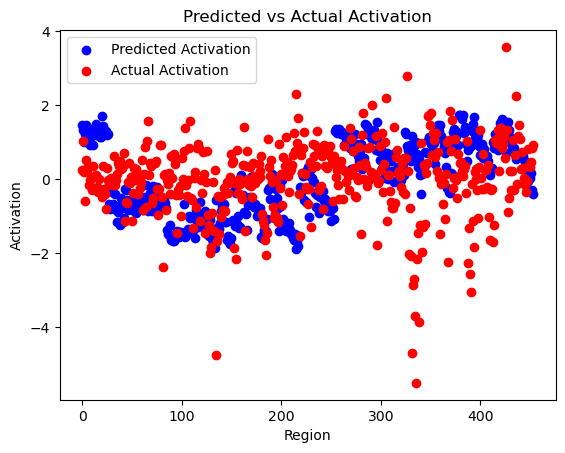

In [54]:
import matplotlib.pyplot as plt
for taskNum in range(numTasks):
    plt.figure()
    plt.scatter(range(numRegions), taskPredMatrix[:, taskNum, 0], color='blue', label='Predicted Activation')
    plt.scatter(range(numRegions), taskActualMatrix[:, taskNum, 0], color='red', label='Actual Activation')
    plt.title('Predicted vs Actual Activation')
    plt.xlabel('Region')
    plt.ylabel('Activation')
    spearman_corr = scipy.stats.spearmanr(taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])[0]
    #plt.text(0.05, 0.95, f'Spearman r = {spearman_corr:.2f}', transform=plt.gca().transAxes, fontsize=12,
             #verticalalignment='top')
    plt.legend()
    plt.show()

In [46]:
print(spearman_corr)

0.01861441064988633


In [31]:
print(taskPredRs)

[[-0.00486599]]
